## Hough Transform
*turns points into lines and lines into dots* 

theoretical background: https://homepages.inf.ed.ac.uk/rbf/HIPR2/hough.htm 

OpenCV tutorial: https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

In [1]:
import os
import time
import pickle
import cv2 as cv
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
from numpy import linalg as LA
from numpy import histogram2d

from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks, butter, filtfilt, welch
from scipy.ndimage import gaussian_filter
from scipy.io import wavfile

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import utils as ut
from utils import try_except_decorator
%load_ext autoreload
%autoreload 2

In [2]:
data_file = "../data/scooter_example_1.wav"
fs, data = wavfile.read(data_file)

# crop data
start_time = 60 # seconds
end_time = 160 # seconds
data = data[int(start_time*fs):int(end_time*fs)]

# data_file = "../data/12062025_example.wav"
# fs, data = wavfile.read(data_file)


# set time annotations
# 1st detection: 3-37 seconds
d1_start = 3
d1_end = 37
# 2nd detection: 91-143 seconds
d2_start = 91
d2_end = 143
# need to account for time cropping
time_annotations = np.zeros_like(data, dtype=int)
if d1_end > start_time and d1_start < end_time:
    s = max(d1_start, start_time) - start_time
    e = min(d1_end, end_time) - start_time
    time_annotations[int(s*fs):int(e*fs)] = 1
if d2_end > start_time and d2_start < end_time:
    s = max(d2_start, start_time) - start_time
    e = min(d2_end, end_time) - start_time
    time_annotations[int(s*fs):int(e*fs)] = 1
print(f"Sample rate: {fs} Hz")
print(f"Data shape: {data.shape}")
print(f"Positive Annotations: {np.sum(time_annotations)} samples, {np.sum(time_annotations)/fs} seconds")
print(f"Negative Annotations: {np.sum(time_annotations==0)} samples, {np.sum(time_annotations==0)/fs} seconds")

f, t, Sxx = ut.get_spectrogram(data, fs, crop_freq=5000)
ut.plot_spectrogram(f, t, Sxx)

/var/folders/3d/d9dsxkl92nz9mr2x53ct_fvh0000gn/T/ipykernel_19927/186884911.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(data_file)


Sample rate: 128000 Hz
Data shape: (12800000,)
Positive Annotations: 6656000 samples, 52.0 seconds
Negative Annotations: 6144000 samples, 48.0 seconds


In [38]:
crop_data = data[int(40*fs):int(50*fs)]
f_crop, t_crop, Sxx_crop = ut.get_spectrogram(crop_data, fs, crop_freq=5000, nperseg=8192)
ut.plot_spectrogram(f_crop, t_crop, Sxx_crop)

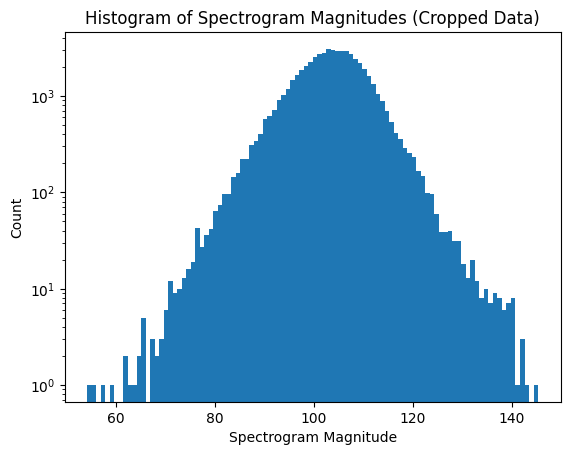

In [39]:
plt.hist(Sxx_crop.flatten(), bins=100)
plt.yscale('log')
plt.xlabel('Spectrogram Magnitude')
plt.ylabel('Count')
plt.title('Histogram of Spectrogram Magnitudes (Cropped Data)')
plt.show()

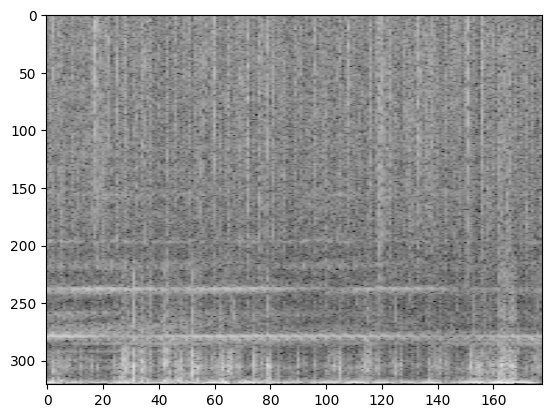

In [53]:
img = np.rot90(np.rot90(Sxx_crop)).astype(np.uint8)  #*255
plt.imshow(img, cmap='gray', aspect='auto')

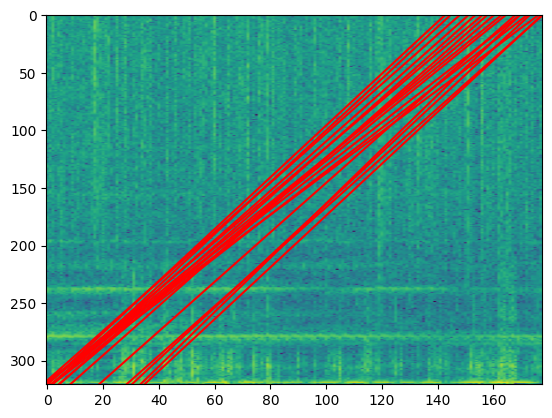

In [55]:
lines = cv.HoughLines(img, 1, np.pi/180, threshold=350, max_theta=np.pi/6)

for l in lines:
    rho, theta = l[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    plt.plot((x1, x2), (y1, y2), 'r')
plt.imshow(img, aspect='auto')
plt.show()

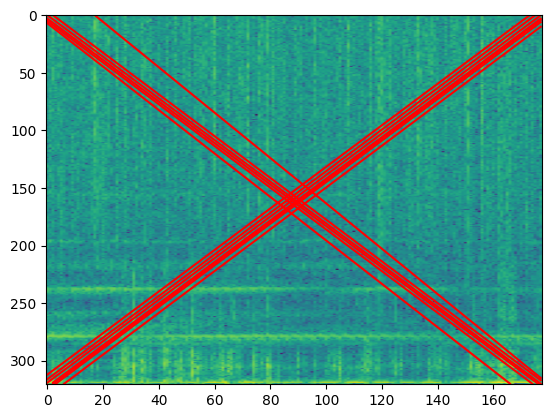

In [57]:
linesP = cv.HoughLinesP(img, 1, np.pi/180, threshold=350, minLineLength=50, maxLineGap=10)
for l in linesP:
    x1, y1, x2, y2 = l[0]
    plt.plot((x1, x2), (y1, y2), 'r')
plt.imshow(img, aspect='auto')
plt.show()